In [1]:
# （1）Setup
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow import keras
from keras import layers, backend
from keras.models import Model


# build x_train y_train x_val y_val    1-to-1，the 1 maybe 1h, maybe 2h.
def BuildXY(data):
    n = data.shape[0]
    x = data[:n-1,...]
    y = data[1:,...]
    return x, y

# Custom functions
def tf_ssim_loss(y_true,y_pred):
    total_loss=1-tf.image.ssim(y_true,y_pred,max_val=1)
    return total_loss   

def rmse(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return backend.sqrt(backend.mean(tf.math.squared_difference(y_pred, y_true)))

def rmse1(x,y):
    rmse = np.sqrt(np.mean(np.square(y-x)))
    return rmse

In [2]:
# （2）Configure memory
gpus = tf.config.list_physical_devices(device_type='GPU')
# True: show the detailed CPU & GPU allocation information
tf.debugging.set_log_device_placement(False)
tf.config.set_soft_device_placement(False)
# only set the specified GPUs visible, otherwise the GPUs will assert different configurations for GPUs
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)

In [3]:
#（3）Construct dataset
# Load data, convert the type to float32, and add a dimension
dataset = np.load('/home/tsj/BACKUP/HSM/dataset/nedata17-19-2h.npy')/1e10
#dataset = np.load('D:/DATASET/ne_data/nedata17-19-2h.npy')/1e10
dataset = np.expand_dims(dataset, axis=-1)
print('dataset:The maxv is',np.max(dataset),',The minv is ',np.min(dataset))
dataset = dataset.reshape(365*3, 23*12, 37, 37, 1)

# build x_train y_train x_val y_val
train_dataset = dataset[0:730, ...]
val_dataset = dataset[730:911, ...]   
test_dataset = dataset[911:, ...] 

# Apply the processing function to the datasets.m个（al,la,lo,1）预测n个（al,la,lo,1）
x_train, y_train = BuildXY(train_dataset)
x_val, y_val = BuildXY(val_dataset)
x_test, y_test = BuildXY(test_dataset)
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))
print("Testing Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

dataset:The maxv is 225.56804 ,The minv is  2.3961146e-16
(1095, 276, 37, 37, 1)
Training Dataset Shapes: (729, 276, 37, 37, 1), (729, 276, 37, 37, 1)
Validation Dataset Shapes: (180, 276, 37, 37, 1), (180, 276, 37, 37, 1)
Testing Dataset Shapes: (183, 276, 37, 37, 1), (183, 276, 37, 37, 1)


In [4]:
#（4）Construct model
'''
# Construct the input layer with no definite frame size.
ConvLSTM2D(batch_size, num_frames, width, height, channels)
# encoder:3 `Conv3D` layers with 'MaxPooling3D',
# followed by a `ConvLSTM2D` layer with batch normalization,
# decoder:3 `Conv3D` layers with 'UpSampling3D'
# last,followed by a `Conv3D` layer for the spatiotemporal outputs.
'''
inputs = layers.Input(shape=(x_train.shape[1:]))   # (None, 552, 37, 37, 1),
# Encoder
n_filters = 32
kernelsize =(3, 3, 3)
poolsize = (4, 2, 2)
x = layers.Conv3D(filters=n_filters, kernel_size=3, activation="relu", padding="same")(inputs)
x = layers.MaxPooling3D(pool_size=poolsize,padding="same")(x)
x = layers.Conv3D(filters=n_filters, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling3D(pool_size=poolsize,padding="same")(x)
x = layers.Conv3D(filters=n_filters, kernel_size=(3, 1, 1), activation="relu", padding="same")(x)  
x = layers.MaxPooling3D(pool_size=poolsize, padding="same")(x) 

# ConvLSTM2D
x = layers.ConvLSTM2D(filters=n_filters,kernel_size=3, padding="same",return_sequences=True, activation="relu")(x)
x = layers.BatchNormalization()(x)     

# Decoder
x = layers.Conv3D(filters=n_filters, kernel_size=(3, 1, 1), activation="relu", padding="same")(x) 
x = layers.UpSampling3D(size=poolsize)(x)
x = layers.Conv3D(filters=n_filters, kernel_size=3, activation="relu", padding="same")(x)
x = layers.UpSampling3D(size=poolsize)(x)
x = layers.Conv3D(filters=n_filters, kernel_size=3, activation="relu", padding="same")(x)
x = layers.UpSampling3D(size=poolsize)(x)

# Output
outputs = layers.Conv3D(filters=1, kernel_size=(45, 4, 4), activation="relu")(x)

# Next, we will build the complete model and compile it.
model = Model(inputs, outputs, name="Ne17-19-24h")
model.summary()

Model: "Ne17-19-24h"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 276, 37, 37, 1)]  0         
                                                                 
 conv3d (Conv3D)             (None, 276, 37, 37, 32)   896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 69, 19, 19, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 69, 19, 19, 32)    27680     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 18, 10, 10, 32)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 18, 10, 10, 32)    

In [5]:
# （5）Train model
start_time = time.time()    # 训练开始时间
model.compile(
    loss=rmse,
    optimizer=keras.optimizers.Adam(),
    metrics=["acc"],
)
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 4


# Fit the model to the training data.
model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()    # 训练结束时间
run_time = end_time - start_time
print('训练时间：',run_time/60,'分钟')

Epoch 1/100
183/183 [==============================] - 104s 484ms/step - loss: 13.5214 - acc: 7.2609e-09 - val_loss: 9.1404 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 2/100
183/183 [==============================] - 87s 474ms/step - loss: 7.8920 - acc: 3.6304e-09 - val_loss: 6.3964 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 3/100
183/183 [==============================] - 86s 473ms/step - loss: 5.8309 - acc: 3.6304e-09 - val_loss: 4.7558 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 4/100
183/183 [==============================] - 86s 473ms/step - loss: 4.9459 - acc: 3.6304e-09 - val_loss: 4.5172 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 5/100
183/183 [==============================] - 86s 472ms/step - loss: 4.2375 - acc: 3.6304e-09 - val_loss: 4.5841 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 6/100
183/183 [==============================] - 87s 473ms/step - loss: 3.9180 - acc: 3.6304e-09 - val_loss: 3.5183 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 7/100
183/183 [==============================] - 8

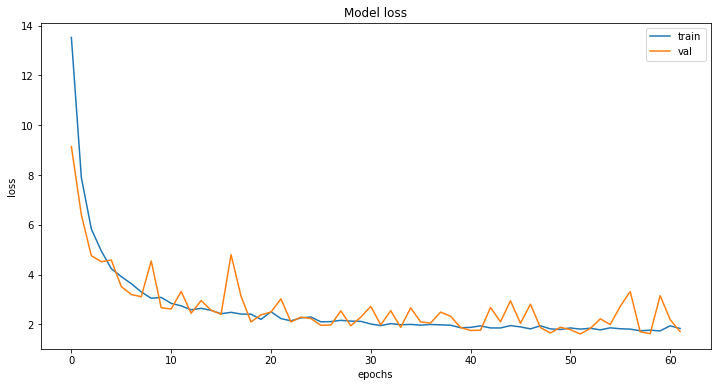

In [6]:
# （6）Visualize model performance
# Here the model loss for the training and the validation sets are plotted. 
fig = plt.subplots(figsize=(12, 6))
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_" + "loss"])
plt.title("Model {}".format("loss"))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

# （7）保存结果
model.save('/home/tsj/BACKUP/HSM/NeModel17-19-24h.h5')
np.save('/home/tsj/BACKUP/HSM/Metric17-19-24h',model.history.history)

In [7]:
# （8）Predict and evaluate performance
T = dataset.shape[0]-1
RMSE = np.zeros((T*12),dtype='float32')
for t in range(T):
    example = np.expand_dims(dataset[t], axis=0)   #(1,23*12, 37, 37,1),第n小时的nedata，
    Pre_nemaps = np.squeeze(model.predict(example))  #(1,23*12, 37, 37,1)，预测的第n+1小时的nedata
    Ori_nemaps = np.squeeze(dataset[t+1]).reshape(12, 23, 37, 37)
    Pre_nemaps = Pre_nemaps.reshape(12, 23, 37, 37)
    for h in range(12):
        RMSE[t*12+h] = rmse1(Pre_nemaps[h] , Ori_nemaps[h]) 

np.save('/home/tsj/BACKUP/HSM/20240930/RMSE17-19-24h-2', RMSE)

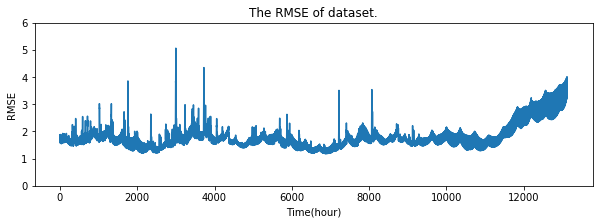

In [9]:
# （9）Plot RMSE
t = np.arange(RMSE.size)
fig = plt.figure(figsize=(10, 3))
plt.plot(t, RMSE)
plt.title('The RMSE of dataset.')
plt.xlabel("Time(hour)")
plt.ylabel("RMSE")
plt.ylim(0,6)
plt.show()